In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from aide_design import physchem as pc

from aide_design.units import unit_registry as u

from aide_design import utility as ut

from aide_design import floc_model as floc

# DC Mechanical Flocculation Solution

In this design challenge, you will design a mechanical flocculator and power unit. You will use a flow rate of 50 L/s as your default design value. The coldest temperature that the raw water is expected to have is 10°C.  
You will also play with fractal flocculation model equations to get a sense of how fast flocs can aggregate. You will also explore the floc model predictions. 

As you define variables, take care not to redefine parameters. One trick is to use a unique name for variables that are estimates. We often add "est" to any variable names that aren't the final values. 

The `floc_model.py` file contains many useful functions which includes clay, coagulant and humic acid material properties, fractal model equations, and flocculation model equations. **We recommend that you open the `floc_model.py` and have it side by side with this design challenge for easy reference.**



<div class="alert alert-block alert-info">

 The course slides found on the syllabus will be very useful for obtaining and understanding relevant equations for this design challenge and ones in the future.

## Conventional Design Guidelines:

This table for mechanical flocculators is taken from Sincero and Sincero's 1996 textbook: *Environmental Engineering: A Design Approach *

Type | Velocity Gradient (G) (1/s) | Energy Dissipation Rate | Gt | t (min)
:---: | :---: | :---: | :---: | :---: 
Low turbidity, color removal | 20-70 | 0.4 - 4.9 | 50,000 - 250,000 | 11 - 210
High turbidity, solids removal | 70 - 180 | 4.9 - 32 | 80,000 - 190,000 | 7 - 45

Dissolved organic matter impacts the color of the water. Perhaps the reason for lower G values for color removal is because flocs created from dissolved organic matter are weaker or less dense. Hence, a lower G is needed to allow them to grow large enough for removal in the sedimentation tank.

## Mechanical Flocculator Design:

The conventional design guidelines provide a range of values with little guidance on how to select "velocity gradient" or G values. One approach is to hope for the best and choose a G value in the middle of the range. We will pick the G value that is apparently appropriate for both low and high turbidity waters.

In [2]:
flow_plant = 50 * u.L/u.s
G_mech = 70 / u.s
temp_design = 10 * u.degC

### 1)

The [Ten State Standards ](http://10statesstandards.com/) (with the hilarious acronym GLUMRB) requires the residence time in a mechanical flocculator to be 30 minutes. What is the value of Gt if you use the velocity gradient given above as `G_mech`? 

Note: `.to(u.dimensionless)` ensures you don't get weird dimensions like kilometer/inch or minute/second for dimensionless parameters.

In [3]:
#answer
time_mech = 30 * u.min
Gtime_mech= (G_mech * time_mech).to(u.dimensionless)

print('The Gt is', ut.sig(Gtime_mech,6))

The Gt is 126000


### 2)

Calculate the equivalent average energy dissipation rate (in mW/kg) for the given velocity gradient at the design temperature. 

In [4]:
#answer
ed_rate_mech_ave = (G_mech**2 * pc.viscosity_kinematic(temp_design)).to(u.mW/u.kg)


print('The equivalent average energy dissipation rate is' , ut.sig(ed_rate_mech_ave,2))

The equivalent average energy dissipation rate is 6.4 mW/kg


### 3)

Create a function to calculate the power requirement for mechanical flocculators. Then, use your function to obtain the power requirement for the design temperature. The equation for power is the same one that we used for mechanical rapid mix units. 

In [5]:
#answer
def power_floc_shaft(Q, G, t, temp):
    return (G**2 * Q * t * pc.viscosity_dynamic(temp)).to(u.kW)
power_mech_floc = power_floc_shaft(flow_plant,G_mech,time_mech,temp_design)
print('The power requirement is', ut.sig(power_mech_floc,2))

The power requirement is 0.57 kW


Fun Fact: although the design guidelines would logically predict that  the power requirements are higher for cold water, there is little evidence that mechanical flocculator plants actually increase the power input to their flocculators when the water is cold.

### 4)

We hypothesize that the ** *maximum* ** energy dissipation rate in a flocculator determines the size of the flocs, and those flocs may or may not be captured by the sedimentation tank. Sedimentation tank performance will deteriorate if the maximum energy dissipation rate results in flocs that are so small that their sedimentation velocity is lower than the capture velocity of the sedimentation tank. This occurs for very high maximum energy dissipation rates. Mechanical flocculators have traditionally been designed without insight into the variability of the energy dissipation rate and the need to keep the maximum energy dissipation rate low enough to prevent the creation of flocs that will avoid capture by the sedimentation tanks. At the same time, the traditional standards likely evolved to produce designs that were at least reasonable even in the absence of an understanding of the fluid mechanics of the mixing process.

According to the Ten State Standards, "Agitators (Flocculators) shall be driven by variable speed drives with the peripheral speed of paddles ranging from 0.5 to 3.0 feet per second." Note that they do not specify the size of the propeller and yet that is a critical dimension that determines the energy dissipation rate in the wake of the spinning propeller.

The wake behind the propeller or paddle is similar in size to the small dimension of the propeller or paddle normal to the velocity. Thus we can use the propeller height to estimate the energy dissipation rate of the plate wake. The relative velocity between the wake and the surrounding fluid is approximately equal to the propeller velocity.  
- Calculate the maximum energy dissipation rate that occurs in the wake behind the tip of a propeller which has a height of 3 cm and is moving at 3 ft/s. In this case, assume that the plate ratio for the maximum energy dissipation rate in the wake, $\Pi_{Plate}$, is 0.34. 

$$\epsilon=\frac{\left ( \Pi_{Plate}V  \right )^{3}}{W_{Plate}}$$

You may assume that the relative velocity between propeller and water is equal to 75% of the propeller velocity.

In [6]:
#answer
ratio_prop_vel = 0.75
pi_plate = 0.34
vel_prop = 3 * u.ft/u.s
height_prop = 3 * u.cm

ed_rate_prop_max = ((ratio_prop_vel * pi_plate * vel_prop)**3 / height_prop).to(u.mW/u.kg)

print('The maximum energy dissipation rate behind the propeller tip is', ut.sig(ed_rate_prop_max,3))

The maximum energy dissipation rate behind the propeller tip is 423 mW/kg


### 5)

Calculate the ratio of maximum to average energy dissipation rate (henceforth referred to as Max/Ave EDR) and the ratio of maximum to average velocity gradient (Max/Ave G) for the mechanical flocculator described above. What is the relationship between the two ratios?

In [7]:
#answer
ed_rate_mech_ratio = ed_rate_prop_max / ed_rate_mech_ave
print('The ratio of maximum to average energy dissipation rate is', ut.sig(ed_rate_mech_ratio,3))

G_mech_ratio = ed_rate_mech_ratio**0.5
print('The ratio of maximum to average velocity gradient is', ut.sig(G_mech_ratio,3))

The ratio of maximum to average energy dissipation rate is 66.3
The ratio of maximum to average velocity gradient is 8.15


SOLUTION NOTE: this information is found on extra slide 48 in the Flocculator Design slids, heading is "Results of the the CFD analysis and our model equations."


High ratios of Max/Ave for velocity gradients (and therefore also energy dissipation rates) are common in both mechanical and hydraulic flocculators. A high velocity gradient ratio is a poor design for two reasons.
 - This high Max/Ave G results in significant inefficiency in the use of energy for flocculation. This inefficiency requires longer residence times and/or more energy input to achieve the same extent of flocculation.   
 - The high energy dissipation rate in the propeller wake limits the amount of energy that can be dissipated without causing excessive floc breakup. Excessive floc breakup produces flocs that are too small to be captured by the sedimentation tank. 
 
We hypothesize that the maximum G values specified for mechanical flocculators were likely set by the constraint of not breaking flocs into small sizes. Sedimentation velocity needs to be less than capture velocity for a floc to settle - the smallest floc that will settle is referred to as the threshold floc because that is the smallest size we want to make. Because well-designed hydraulic flocculators have more uniform shear rates (as compared to mechanical flocculators), hydraulic flocculators are less likely to break up flocs. Therefore, the average G values specified for mechanical flocculators are not expected to apply to well designed hydraulic flocculators.

The high energy dissipation rates at the tip of a propeller in a flocculator may be high enough to create flocs that are too small to be captured by the sedimentation tanks. We will determine if the sedimentation tank could capture these flocs in the analysis below.

These results also suggest that the traditional emphasis on maintaining the same or lesser G value for the transport of flocculated water to the sedimentation tank may have missed the more important point of not exceeding a value of G that produces flocs that are too small to be captured by the sedimentation tank.

### 6)

A mechanical flocculator is treating high turbidity water, and therefore is using an * **average ** * G value of 180 Hz. 

If the design guidelines for maximum G for mechanical flocculators are correct and are based on floc breakup, then what is the largest * ** average** * G that could be used for a well designed hydraulic flocculator with a Max/Ave G of $\sqrt{2}$?

Note: important distinctions to make are: 
- maximum G vs average G 
- mechanical vs hydraulic flocculators. Conceptual thought coupled with pencil and paper are recommended. 

In [8]:
#answer
G_hyd_ratio = np.sqrt(2)
G_mech_ave_max = 180 * u.Hz
G_hyd_ave_max = G_mech_ave_max * (G_mech_ratio/G_hyd_ratio)
print('The maximum G for hydraulic flocculators is', ut.sig(G_hyd_ave_max,4))

The maximum G for hydraulic flocculators is 1037 Hz


These extremely high average G values are more like traditional rapid mix. It is possible that energy use constraints (too much elevation difference required to power the flocculation) will prevent use of such high G values. It is also possible that these G values would cause excessive floc break up even though they appear to meet conventional standards.

### 7)
How much energy in Joules per liter would be required to treat the water using this mechanical flocculator?

In [27]:
#answer
def energy_mech(Q, G, t, temp):
    return (power_floc_shaft(Q, G, t, temp) / Q).to(u.J/u.L)


print('The energy required using the mechanical flocculator is', ut.sig(energy_mech(flow_plant,G_mech,time_mech,temp_design),3))

The energy required using the mechanical flocculator is 11.5 J/l


### 8)

How much does the electricity cost to flocculate a million liters? It isn't necessary to actually size an electric motor for this assignment. Simply use the shaft power and assume a motor efficiency of 80%. Use the price of electricity that you obtained in the Rapid Mix design challenge. Hard code this price as a variable.

In [11]:
#answer
efficiency_motor = 0.8
electricity_rate = ((0.146 * u.USD) / (u.kW * u.hr))


electricity_cost_mech = (electricity_rate * energy_mech(flow_plant,G_mech,time_mech,temp_design) / efficiency_motor).to(u.USD/u.ML)
print('The cost of electricity for mechanical flocculation is', ut.sig(electricity_cost_mech,2))

The cost of electricity for mechanical flocculation is 0.58 USD/Ml


It doesn't actually cost very much to flocculate water using electricity. We will create cost savings over mechanical flocculators by designing smaller, higher performing flocculators that don't require any moving parts and thus don't require much maintenance. Our capital costs will also be lower because we use more efficient plug flow reactors to prevent short circuiting of particles through the flocculator.

### 9)

What is the equivalent amount of potential energy that is used to operate this mechanical flocculator (the shaft power) expressed as an elevation drop in meters?

In [15]:
#answer
delta_height = (power_floc_shaft(flow_plant,G_mech,time_mech,temp_design) / (flow_plant * pc.density_water(temp_design) * pc.gravity)).to(u.m)

print('The equivalent amount of potential energy to run this  mechanical flocculator is', ut.sig(delta_height,3))

print(power_floc_shaft(flow_plant,G_mech,time_mech,temp_design))

The equivalent amount of potential energy to run this  mechanical flocculator is 1.17 m
0.5730957660614814 kilowatt


### 10)

What is the required reactor volume for the mechanical flocculator?

In [16]:
#answer
vol_mech = (time_mech * flow_plant).to(u.m**3)
print('The required reactor volume for the mechanical flocculator is', vol_mech)

The required reactor volume for the mechanical flocculator is 90.0 meter ** 3


### 11)

If this flocculator is 4 m deep, then how many square meters of plan view area are required per L/s of flow capacity? This is a measure of required size of this unit process. For comparison, an AguaClara sedimentation tank requires about $\frac{1m^{2}}{L/s}$ and are only 2 m deep.

In [17]:
#answer
depth_mech = 4 * u.m
area_mech = (vol_mech / (depth_mech * flow_plant))
print('The required plan view area is', area_mech)

The required plan view area is 0.45 meter ** 2 * second / liter


## Fractal Flocculation Model

Many of the fractal floc equations are available in the `floc_model.py` file in the aide_design repository. You will need to look through that code to see what functions are available. The following constants are defined in that file.
NTU has been defined as an approximate empirical relationship between the concentration of kaolin clay and the turbidity, such that 1 NTU is equivalent to 1.7 mg/L. The diameter of a primary clay particle is assumed to be 7 micrometers. The fractal dimension for flocs is defined as `DIAM_FRACTAL` and is equal to 2.3. We are using PACl as a coagulant for this analysis, so you shall call `floc.PACl`, when a function within `floc_model.py` requires 'coag' as an input.

<div class="alert alert-block alert-info">

### Look through `floc_model.py` within aide_design. You will be using it heavily in the following section
Whenever possible, use variables defined within `floc_model.py` instead of redefining them. Relevant variables defined in `floc_model.py` include:
<br>
<br>
1. `DIAM_FRACTAL` <br>
     Recall in class that Monroe mentioned that this is not actually a diameter, but rather a dimension. It has been incorrectly and misleadingly named in aide_design. It's value is simply 2.3, and it has no units.

1. `PACl`  
1. `Clay`

### 12)

Estimate the diameter of the flocs that interact with the tip of the impeller of the mechanical flocculator analyzed above. We don't yet have a good model to predict maximum floc size as a function of velocity gradient or energy dissipation rate. We have a rough estimate, `floc.diam_floc_max(EDRmax)` based on a small amount of data. 

In [18]:
#answer
diam_floc_mech = floc.diam_floc_max(ed_rate_prop_max).to(u.um)
print('The diameter of the flocs that interact with the impeller is', ut.sig(diam_floc_mech,3)+'.')

The diameter of the flocs that interact with the impeller is 127 um.


### 13)

Estimate the terminal sedimentation velocity in mm/s of the flocs that interact with the tip of the impeller of the mechanical flocculator analyzed above. Use the function `floc.vel_term_floc`. You may assume that the flocs were made from a particle suspension that had 1.5 mg/L of aluminum and 100 NTU of clay.

Note: AguaClara has defined the unit NTU as `u.NTU`.

In [19]:
#answer
conc_Al = 1.5 * u.mg/u.L
conc_clay=100*u.NTU
vel_term_floc_tip = floc.vel_term_floc(conc_Al, conc_clay, floc.PACl,
                                       floc.Clay, floc.DIAM_FRACTAL, 
                                       diam_floc_mech, temp_design).to(u.mm/u.s)

print('The terminal velocity of flocs that interact with the impeller tip is estimated to be', ut.sig(vel_term_floc_tip,3))

The terminal velocity of flocs that interact with the impeller tip is estimated to be 0.738 mm/s


### 14)

Would these flocs be captured by a conventional design for a sedimentation tank [(10 State Standards)](http://10statesstandards.com/waterrev2012.pdf) with a capture velocity of 1.2 m/hr? The capture velocity is a property of the sedimentation tank. If the floc settles faster than the capture velocity, then theoretically the floc will be captured by the sedimentation tank.

In [20]:
#answer
vel_capture_10_state = (1.2 * u.m/u.hr).to(u.mm/u.s)
print('The 10 State Standards capture velocity is', ut.sig(vel_capture_10_state,3))
print("The 10 State Standards sedimentation tank would capture the flocs that are able to survive the energy dissipation rate at the tip of the propeller. ")

The 10 State Standards capture velocity is 0.333 mm/s
The 10 State Standards sedimentation tank would capture the flocs that are able to survive the energy dissipation rate at the tip of the propeller. 


These flocs would be removed easily in an AguaClara sedimentation tank (capture velocity of 0.12 mm/s). However, our use of the empirical equation to predict the size of these flocs is questionable because we are extrapolating way beyond the original data. We need more experiments to characterize the size of flocs as a function of the velocity gradient.

### 15)

Estimate the average distance between primary clay particles at the beginning and end of flocculation given an initial turbidity of 100 NTU and a target effluent unflocculated clay concentration at the end of flocculation of less than 1 NTU. Of course, the clay concentration is actually constant in flocculation since particles are not actually being removed. But here we are referring to the primary clay particles that have escaped aggregation and thus are still unattached. 

You can do this by figuring it out empirically (brownie points!) or by looking for a function that finds average distance between particles.

A little extra to think about (not necessary to answer): The AguaClara floccuation model assumes that primary clay particles mostly attach to other primary clay particles and not to larger flocs (aggregates of clay particles). Can you think of why this is?


In [21]:
#answer
init_sep_dist_clay = floc.sep_dist_clay(100 * u.NTU, floc.Clay).to(u.mm)
final_sep_dist_clay = floc.sep_dist_clay(1 * u.NTU, floc.Clay).to(u.mm)
print('The average distance between clay particles at 100 NTU is', ut.sig(init_sep_dist_clay,3))
print('The average distance between clay particles at 1 NTU is', ut.sig(final_sep_dist_clay,3))

The average distance between clay particles at 100 NTU is 0.141 mm
The average distance between clay particles at 1 NTU is 0.654 mm


### 16)

What is the inner viscous length scale in the mechanical flocculator at the maximum energy dissipation rate? Given that this is a very high energy dissipation rate for flocculation, it corresponds to a very small inner viscous length scale. This means that eddies are able to survive down to a small size before viscosity damps their motion. If the separation distance between clay particles that haven't turned into flocs is less than this inner viscous scale, then it is reasonable to assume that all flocculation is dominated by viscosity. The function within `floc_model.py` that does this is confusingly named `lamba_vel()`.

In [22]:
#answer
print('The inner viscous length scale is', ut.sig(floc.lambda_vel(ed_rate_prop_max, temp_design).to(u.mm),3))

The inner viscous length scale is 2.39 mm


### 17)
Below is a graph showing the inner viscous length scale that divides flows that are dominated by inertia (eddies) from flows where viscosity is significant. **Add the data point** representing the maximum energy dissipation rate vs the maximum clay separation distance at the end of flocculation for the mechanical flocculator you have been designing.

0.6541789493547243 millimeter
422.57902694348155 milliwatt / kilogram


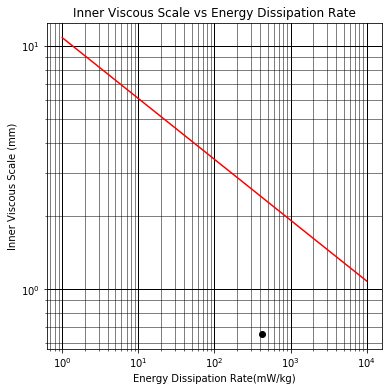

In [26]:
#This code is provided to help you make your graph

#Creates the array for energy dissipation rates (EDRs)
x = np.logspace(np.log10(1),4)*u.mW/u.kg

plt.figure('Inner Viscous Scale', (6,6))
plt.title('Inner Viscous Scale vs Energy Dissipation Rate')

plt.ylabel('Inner Viscous Scale (mm)')
plt.xlabel('Energy Dissipation Rate(mW/kg)')

plt.yscale('log')
plt.xscale('log')

plt.grid(b=True, which='major', color='k', linestyle='-', linewidth=1)
plt.grid(b=True, which='minor', color='k', linestyle='-', linewidth=0.5)

#floc.lambda_vel, which returns the inner viscous length scale, 
#is being applied to the array of EDRs for our design temperature
y = floc.lambda_vel(x,temp_design)
plt.plot(x, y.to(u.mm), 'r')

#------------------------------------------------------------------------
#----------------------------YOUR CODE BELOW-----------------------------
#------------------------------------------------------------------------
#answer
plt.plot(ed_rate_prop_max.to(u.mW/u.kg), final_sep_dist_clay.to(u.mm), 'ko')



print(final_sep_dist_clay)
print(ed_rate_prop_max)

plt.show()

### 18)

According to the plot and analysis above, are the collisions between clay particles at a concentration of 1 NTU dominated by inertia or by viscosity? Explain why!

The final spacing between clay particles is still smaller than the inner viscous length scale at which eddies are damped by viscosity. This suggests that all collisions in flocculation are dominated by viscosity.

<div class="alert alert-block alert-info">

# Real-world considerations of flocculation
Now that you have an augmented understanding of flocculation theory, we can consider a few ways in which the theory applies to real-world flocculators. 

In this section, there are no calculations for you to do or code for you to write - everything has been provided for you. This was done to shorten this design challenge while still detailing relevant and important information.

<br>
**There are two conceptual questions for you to answer at the end of the section.** Read through and focus on understanding the concepts before you try to answer the questions. 

### Coagulant distribution in a reactor

The flocculation model accounts for loss of coagulant nanoparticles to the reactor walls. The loss of coagulant nanoparticles is assumed to scale with the area of the flocculator walls divided by the total area of clay and flocculator walls. This loss is significant for low turbidity and small scale flocculators, such as the 1 liter per second flocculator AguaClara recently designed.

Here we will consider a flocculator built out of pipe, not one contained within a rectangular reactor. The `diam_tube` parameter is the flocculator diameter and is needed to estimate how much of the coagulant is lost to the walls of the flocculator. We will assume the flocculator tube is for the 1 L/s plant and has a diameter of 7.5 cm 

We will evaluate the situation where the turbidity is 10 NTU and the coagulant dose is 1 mg/L of aluminum. The code below does the following:

 - Estimates the fraction of coagulant nanoparticles lost to the flocculator walls.
 - Estimates the fraction of the clay surface area that is coated with nanoparticles.

In [ ]:
diam_tube = 7.5 * u.cm
conc_clay = 100*u.NTU
conc_Al = 0.5*u.mg/u.L


#floc.ratio_area_clay_total() returns fraction (between 0 and 1) that represents the surface area of 
#the clay particle over the sum of the surface area of the clay and reactor walls 

wall_loss = 1 - floc.ratio_area_clay_total(conc_clay, floc.Clay, diam_tube, floc.RATIO_HEIGHT_DIAM)
print('The fraction of the coagulant lost to the walls is', ut.sig(wall_loss,3))

#floc.gamma_coag() returns the fraction of clay that is covered by coagulant. This is a very hard parameter 
#to actually measure, so this is just an estimate.

fraction_coated = floc.gamma_coag(conc_clay,conc_Al, floc.PACl, 
                                  floc.Clay, diam_tube, floc.RATIO_HEIGHT_DIAM)
print('The fraction of the clay surface area that is is coated is', ut.sig(fraction_coated,3))

### Time scale of flocculation

Now we want to estimate the average time required for an initial successful collision between two primary clay particles that are partially coated with coagulant nanoclusters. Note that for the first collision, the current floc size is the same as the clay size. We will use the average energy dissipation rate for the mechanical flocculator as found above.

In [ ]:
ed_rate_mech_ave = 6.4*u.mW/u.kg

time_first_collision = floc.time_col_laminar(ed_rate_mech_ave, 10*u.degC, 
                                             conc_Al, conc_clay, floc.PACl, 
                                             floc.Clay, floc.Clay.Diameter, diam_tube,
                                             floc.DIAM_FRACTAL, floc.RATIO_HEIGHT_DIAM).to(u.s)

print('The time required for the first succesful collision is', ut.sig(time_first_collision,3))

This collision time is quite fast and is the origin of the question, "why does flocculation require 30 minutes?" as mandated in the Ten State Standards.

### AguaClara flocculation model
We will now briefly consider an AguaClara flocculator design with an average energy dissipation rate of approximately 11 mW/kg and a residence time of 8.1 minutes. The design temperature is 15 degC. 

Below is a calculation for the Gt value of this flocculator.

In [ ]:
#answer
ed_rate_floc_aguaclara = 11*u.mW/u.kg
time_floc_aguaclara = 8.1*u.minute
temp_design_aguaclara = 15*u.degC

#This equation for G can be found in the course slides (all equations you see in design challenges can be found in the slides) 
G_floc_aguaclara = np.sqrt(ed_rate_floc_aguaclara/pc.viscosity_kinematic(temp_design_aguaclara))
Gtime_floc_aguaclara = (G_floc_aguaclara*time_floc_aguaclara).to(u.dimensionless)
print('The AguaClara Gt value is', ut.sig(Gtime_floc_aguaclara,5))

### Coagulant coverage fraction of a particle

This section solves the integrated flocculation model for $\Gamma$. We simplify the model by recognizing that the spacing between particles at the end of the flocculation process is much greater than the initial particle spacing. This means that the raw water turbidity drops out of the equation. The value of the rate constant for collisions is k = 0.24.  We start with the equation below:

$$\Gamma = \frac{3}{2}\cdot \frac{\Lambda^2 }{\mathit{k} \pi d_{p}^2 Gt }$$

We then estimate the required coagulant coverage of clay, $\Gamma$, for the AguaClara flocculator to achieve a 2 NTU settled water turbidity when starting with a raw water that is 50 NTU.

Note that the specified flocculation model applies to both hydraulic and mechanical flocculators.

In [ ]:
#Fitting constant/Sedimentation tank factor
k = 0.24

#gamma_aguaclara_design uses functions in floc.py to solve the equation in the problem statement
conc_clay_goal = 2 * u.NTU
gamma_aguaclara_design = (3/2) * (floc.sep_dist_clay(conc_clay_goal, floc.Clay)**2
                           / (k * np.pi * (floc.Clay.Diameter * u.m)**2 
                              * Gtime_floc_aguaclara
                             )
                          ).to(u.dimensionless)

print('The Gamma value is', ut.sig(gamma_aguaclara_design,3))

### Residence time and coagulant coverage

If you doubled the residence time of the flocculator, the required coagulant coverage of clay changes according to the model. By doubling the residence time, the required coagulant coverage is reduced by a factor of 2.

### Modeling flocculation in the presence of humic acid, with pC\* as the performance metric

The flocculation model predicts the settled water turbidity given the composition of the raw water, the flocculator characteristics, and a fitting parameter that must be a function of the sedimentation tank characteristics. This fitting parameter is k, which is the same as the rate constant for collisions described above. The model is far from complete - it doesn't yet describe the effects of floc blankets. Below we have created a plot showing model predictions for a range of coagulant and humic acid (dissolved organic matter) concentrations. The plot uses our approximation for pC\* described in class and shown below:


$$pC^*=\frac{3}{2}log{(\frac{2}{3}\pi k \frac{d_p^{2}}{\Lambda_0^{2}}Gt\alpha + 1)}$$


In [ ]:
#Define the range of coagulant. This is necessary to create plots of pC* as a function of coagulant dose.
coag_graph = np.linspace(0.01, 2.5, 100) * u.mg/u.L

# Graph results of a particular NTU. Note that you can change this value to see how the graph responds.
# A change here even changes the graph title changes!
plot_NTU = 50*u.NTU

plt.figure(str(plot_NTU), (6,6))
plt.title(str(plot_NTU)+' Graph for Various Humic Acid Concentrations')
plt.ylabel('pC*')
plt.xlabel('coagulant dosage (mg/L)')

# Create an array of humic acid concentrations
plot_humic_acid = np.linspace(0,15,6)*u.mg/u.L

# Create a function that only has inputs for the values that we will change between plots. 
#All other variables are taken from predefined values. This simplifies the function call for use in generating the plots.
def plot_pC(conc_humic_acid):
    k = 0.24
    # The energy dissipation rate for aguaclara designs
    ed_rate = 11*u.mW/u.kg
    #The inner diameter of the flocculator tube is important because a significant fraction of the
    #coagulant ends up attaching to the flocculator walls
    tube_diam = 3/8 * u.inch
    time_floc = 8.1 * u.minute
    temp = 15 * u.degC
    #pc_viscous is the solution for the equation in the problem statement. It returns pC*
    plot_pC = floc.pc_viscous(ed_rate, temp, time_floc, tube_diam,
                            plot_NTU, coag_graph, conc_humic_acid, 
                            floc.HumicAcid, floc.PACl, floc.Clay,
                            k, floc.RATIO_HEIGHT_DIAM)
    return plot_pC

x = coag_graph.to(u.mg/u.L)
         
plt.plot(x, plot_pC(plot_humic_acid[0]), 'r',
         x, plot_pC(plot_humic_acid[1]), 'b',
         x, plot_pC(plot_humic_acid[2]), 'g',
         x, plot_pC(plot_humic_acid[3]), 'm',
         x, plot_pC(plot_humic_acid[4]), 'c',
         x, plot_pC(plot_humic_acid[5]), 'y')

#We can use the array of humic acid concentrations to directly create the legend!
plt.legend(plot_humic_acid, loc = 'best')
plt.show()

There is a lot to learn from this graph!!!!!! It appears that for any given coagulant dose, humic acid concentration significantly affects pC\*. Additionally, notice the diminishing returns of adding more coagulant. This effect appears to be independent of humic acid concentration (see the red curve).

### Modeling flocculation in the presence of humic acid, with settled water turbidity as the performance metric

We will now display a similar plot which shows settled water turbidity instead of pC\*. Our initial turbidity is 10 NTU, and we will four curves for separate humic acid concentrations. 

In [ ]:
#answer
plot_NTU = 10*u.NTU

plt.figure(str(plot_NTU), (6,6))
plt.title(str(plot_NTU)+' Graph')
plt.ylabel('Settled water turbidity (NTU)')
plt.xlabel('coagulant dosage (mg/L)')

def plot_conc_clay(conc_clay, conc_nat_org_mat):
    k = 0.24
    ed_rate = 11*u.mW/u.kg
    #The inner diameter of the flocculator tube is important because a significant fraction of the
    #coagulant ends up attaching to the flocculator walls
    tube_diam = 3/8 * u.inch
    conc_clay = plot_NTU
    time_floc = 8.1 * u.minute
    temp = 15 * u.degC
    #s_t calls on floc.pc_viscous() like the previous cell of code, but also uses the floc.invp() 
    #function to turn pC* back into units of settled water turbididty.
    s_t = floc.invp(floc.pc_viscous(ed_rate, temp, time_floc, tube_diam,
               conc_clay, coag_graph, conc_nat_org_mat, floc.HumicAcid, floc.PACl, floc.Clay,
                            k, floc.RATIO_HEIGHT_DIAM),conc_clay)

    return s_t

#Creates array of humic acid concentrations. This was done in the previous code cell with np.linspace, 
#but because we don't want evenly spaced concentrations here we input our desired values manually
plot_humic_acid = np.array([0,1,5,20])*u.mg/u.L

x = coag_graph.to(u.mg/u.L)
plt.plot(x, plot_conc_clay(plot_NTU, plot_humic_acid[0]), 'r', 
         x, plot_conc_clay(plot_NTU, plot_humic_acid[1]), 'b', 
         x, plot_conc_clay(plot_NTU, plot_humic_acid[2]), 'g',
         x, plot_conc_clay(plot_NTU, plot_humic_acid[3]), 'y')

plt.legend(plot_humic_acid, loc = 'best')
plt.show()

Looking at the interactions between coagulant, clay, and humic acid from this perspective yields even more fun discoveries! For increasing humic acid concentration, more coagulant is required to even begin the process of flocculation. 

### 19)

Why does the AguaClara flocculation model predict that adding 1 mg/L of aluminum has no effect on turbidity when the humic acid concentration is 20 mg/L?

### Your Answer Here

At low concentrations of coagulant every coagulant nanoparticle surface is completely coated with humic acid and thus they aren't sticky at all. 

### 20)
It is tempting to assume that all the coagulant dosed gets attached to clay particles. However, if a plant operator were to make this assumption, their plant would produce low-quality water. 

Identify and explain two significant reasons as to why this assumption fails.

### Your Answer Here
1. Coagulant is lost to the walls of the reactors
1. Coagulant is lost to humic acid  
(Students need to write more than this)